## TODO compare offset-subtraction to low-pass filtering

In [1]:
# constant-pad outside of probe mask

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N = 64
gridsize = 2
gridh, gridw = 32, 32

obj = np.load('../datasets/Run1084_recon3_postPC_shrunk.npz')

obj['diffraction'].shape

xcoords = obj['xcoords'][:gridh * gridw]
ycoords = obj['ycoords'][:gridh * gridw]

xcoords_start = obj['xcoords_start'][:gridh * gridw]
ycoords_start = obj['ycoords_start'][:gridh * gridw]

import numpy as np
from scipy.spatial import cKDTree

def get_neighbor_indices(xcoords, ycoords, K = 3):
    # Combine x and y coordinates into a single array
    points = np.column_stack((xcoords, ycoords))

    # Create a KDTree
    tree = cKDTree(points)

    # Query for K nearest neighbors for each point
    distances, nn_indices = tree.query(points, k=K+1)  # +1 because the point itself is included in the results
    return nn_indices

nn_indices = get_neighbor_indices(xcoords, ycoords, K = 6)

import numpy as np

def sample_rows(indices, n, m):
    N = indices.shape[0]
    result = np.zeros((N, m, n), dtype=int)
    for i in range(N):
        result[i] = np.array([np.random.choice(indices[i], size=n, replace=False) for _ in range(m)])
    return result

nn_indices = sample_rows(nn_indices, 4, 10).reshape(-1, 4)


diff3d = np.transpose(obj['diffraction'][:, :, :gridh * gridw], [2, 0, 1])
diff3d.shape

diff4d_nn = np.transpose(diff3d[nn_indices], [0, 2, 3, 1])
diff4d_nn.shape

coords_nn = np.transpose(np.array([xcoords[nn_indices], ycoords[nn_indices]]),
            [1, 0, 2])[:, None, :, :]

coords_start_nn = np.transpose(np.array([xcoords_start[nn_indices], ycoords_start[nn_indices]]),
            [1, 0, 2])[:, None, :, :]

2023-08-15 21:23:29.406802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:23:29.494662: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-15 21:23:29.883668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-08-15 21:23:29.883713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = True
    p.cfg['data_source'] = 'lines'
    p.cfg['set_phi'] = True
    p.cfg['nepochs'] = 3
    
    p.cfg['nll_weight'] = 0.
    p.cfg['mae_weight'] = 1.

    p.cfg['offset'] = 4
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 2
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e6
    
    p.cfg['outer_offset_train'] = None
    p.cfg['outer_offset_test'] = None
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1

from ptycho import tf_helper
from ptycho import probe

probe.set_probe_guess(None, obj['probeGuess'])

init()
from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

2023-08-15 21:23:31.430419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 21:23:31.448887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 21:23:31.449031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 21:23:31.687880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
from ptycho import params as p
p.cfg['data_source'] = 'xpp'
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'lines2'

p.cfg['gridsize'] = 2
p.cfg['n_filters_scale'] = 2
p.cfg['object.big'] = True
p.cfg['intensity_scale.trainable'] = True

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (20480, 64, 64, 4)
0.6433304503772547
nphoton 5.999693253934804
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 4)    0           ['input[0][0]']                  
                                                                                                  
 auto_encoder (AutoEncod

2023-08-15 21:23:51.892285: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-08-15 21:23:51.892301: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-08-15 21:23:51.892324: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-08-15 21:23:51.893634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-08-15 21:23:51.954437: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-08-15 21:23:51.954539: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/3
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2023-08-15 21:24:01.196788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-08-15 21:24:02.342305: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x82b8ae0


730/730 [==============================] - 14s 15ms/step - loss: 2.1460 - trimmed_obj_loss: 1.0354 - tf.math.multiply_loss: 2.1460 - distribution_lambda_loss: 348278.4375 - probe_illumination_loss: 1.1512 - val_loss: 1.9485 - val_trimmed_obj_loss: 1.0444 - val_tf.math.multiply_loss: 1.9485 - val_distribution_lambda_loss: 287253.3438 - val_probe_illumination_loss: 1.1512 - lr: 0.0010
Epoch 2/3
730/730 [==============================] - 10s 13ms/step - loss: 1.9145 - trimmed_obj_loss: 1.0517 - tf.math.multiply_loss: 1.9145 - distribution_lambda_loss: 280336.4375 - probe_illumination_loss: 1.1512 - val_loss: 1.8805 - val_trimmed_obj_loss: 1.0504 - val_tf.math.multiply_loss: 1.8805 - val_distribution_lambda_loss: 274119.8750 - val_probe_illumination_loss: 1.1512 - lr: 0.0010
Epoch 3/3
730/730 [==============================] - 10s 13ms/step - loss: 1.8403 - trimmed_obj_loss: 1.0691 - tf.math.multiply_loss: 1.8403 - distribution_lambda_loss: 264755.5312 - probe_illumination_loss: 1.1512 - v

phase min: -3.1264403 phase max: 3.126919


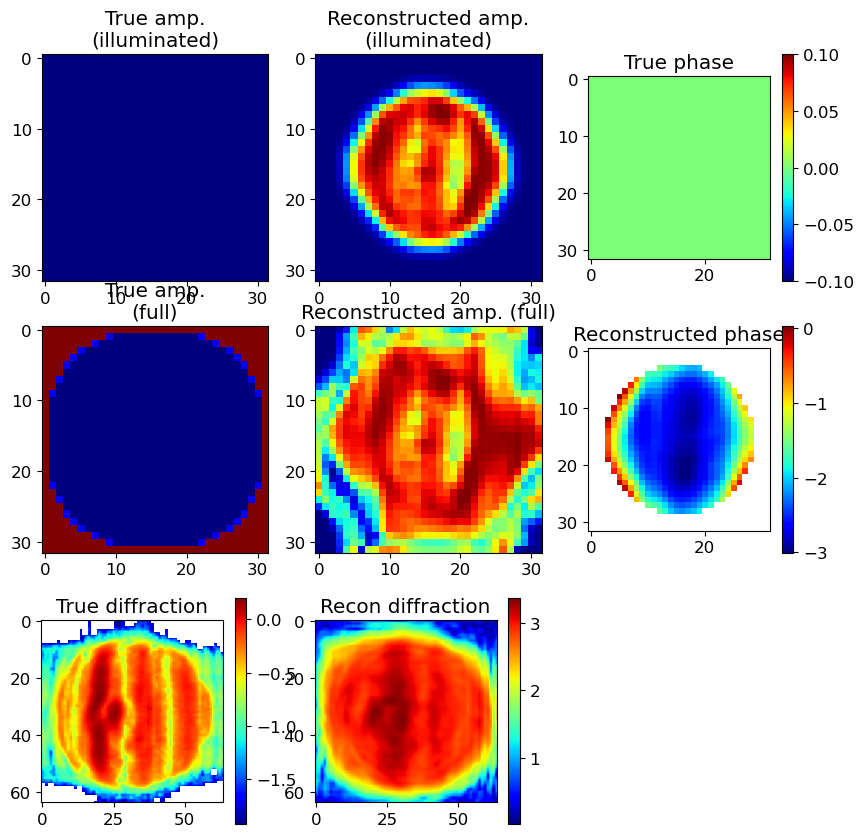

In [5]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -2.9461477 phase max: 1.7586955


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


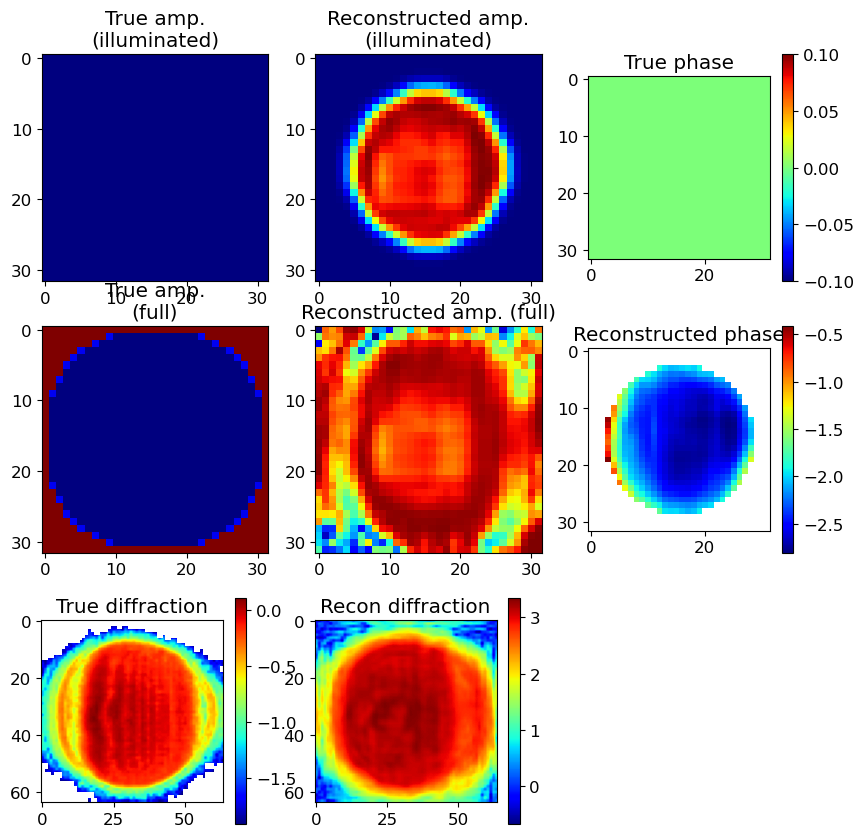

In [4]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -2.9626362 phase max: 3.0357034


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


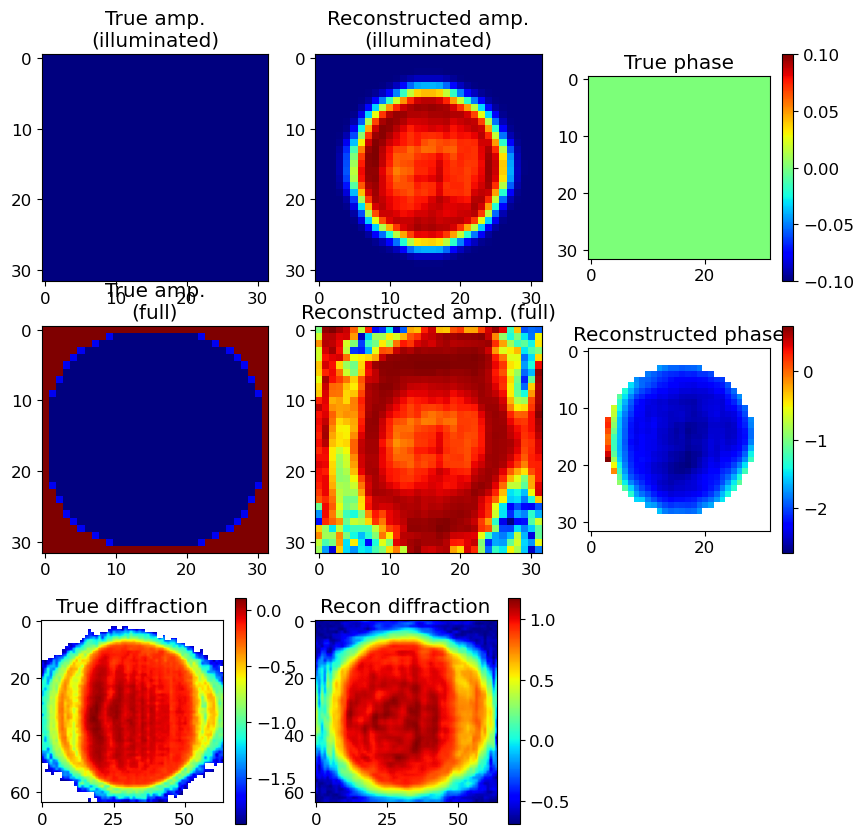

In [4]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.0702643 phase max: 1.6989611


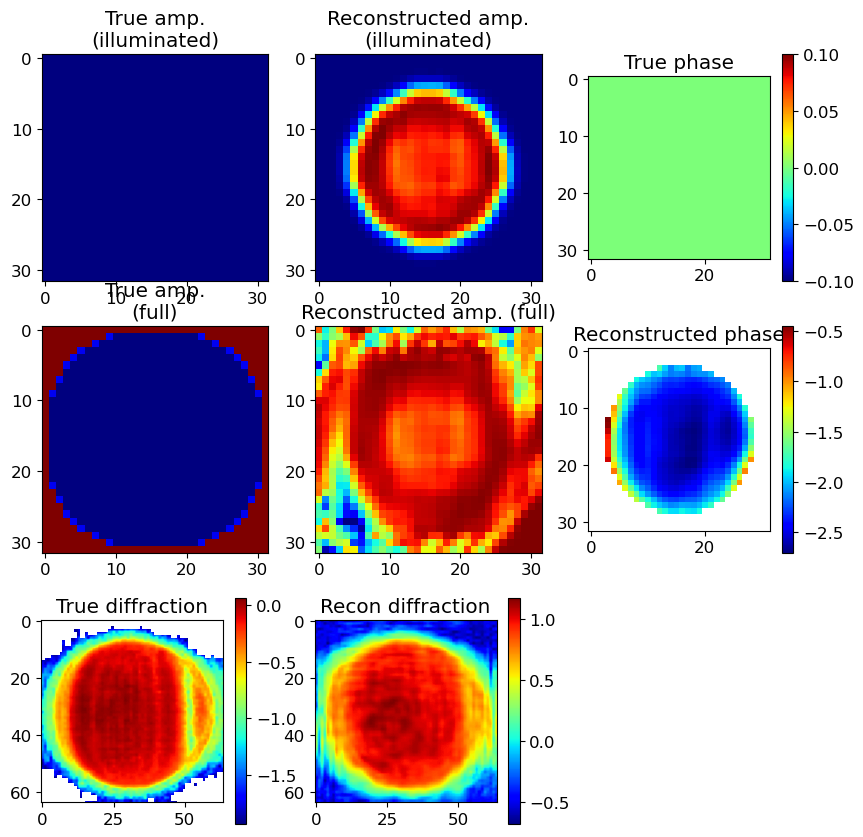

In [9]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.0702643 phase max: 1.6989611


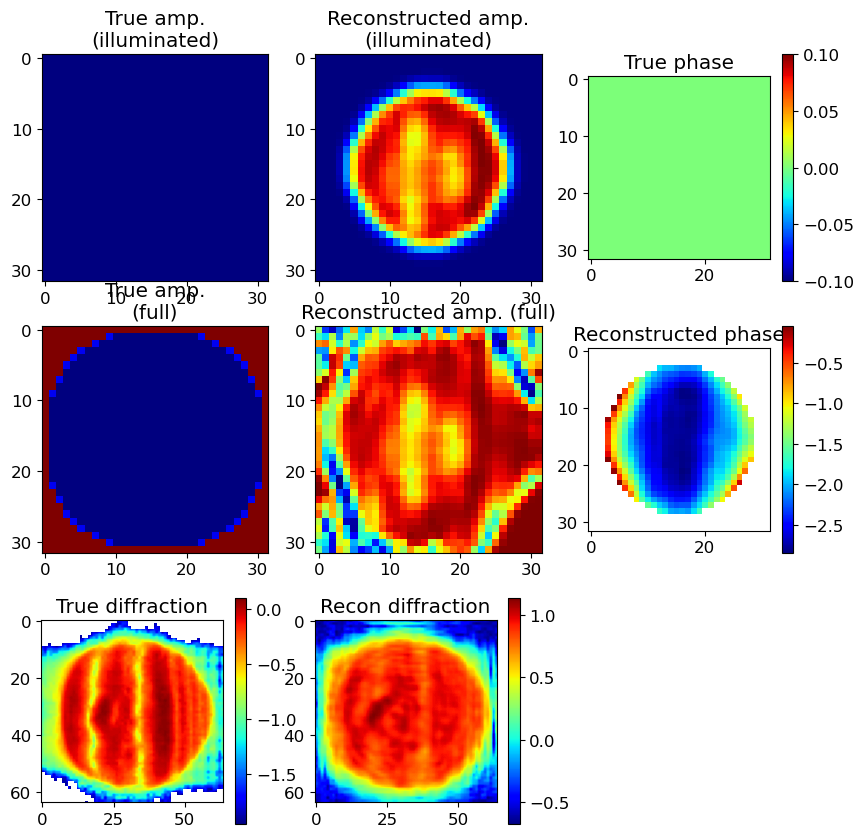

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.0169663 phase max: 3.0628684


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


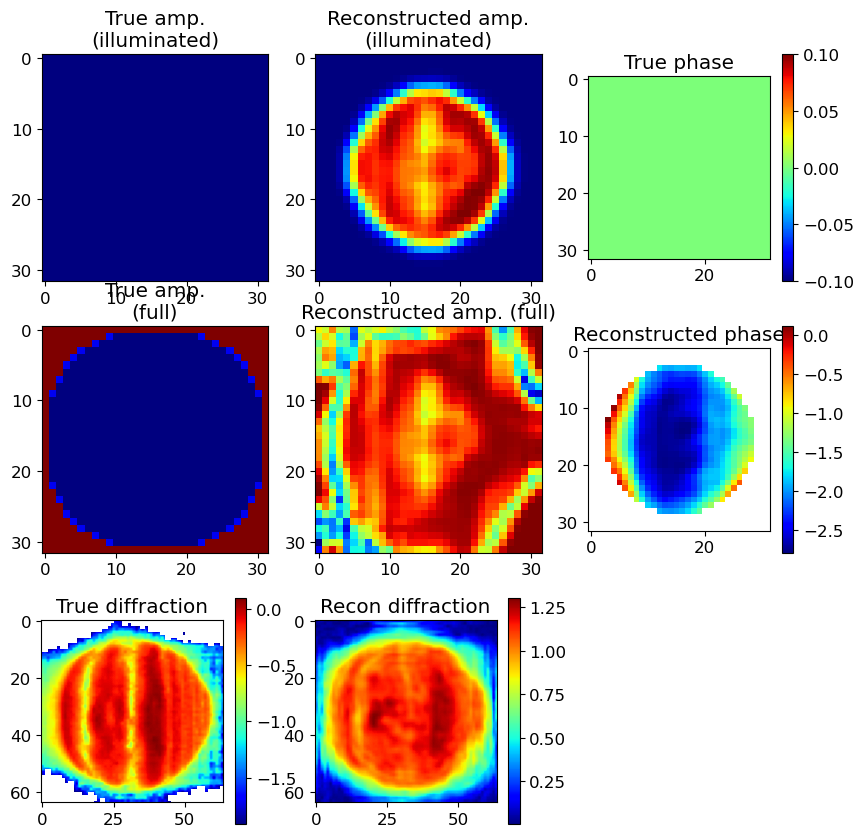

In [6]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.115789 phase max: 1.6128775


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


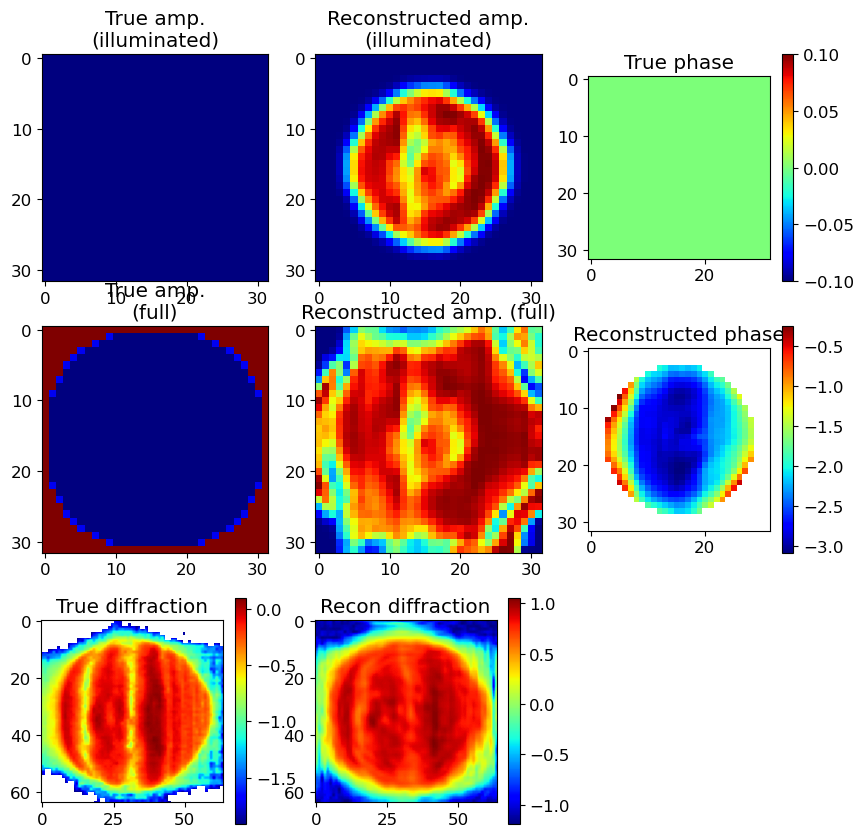

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

In [ ]:
hh.reassemble_nested_average(reconstructed_obj)

In [7]:
reconstructed_obj.shape

(4096, 64, 64, 1)

In [9]:
from ptycho import xpp

In [12]:
xpp.split_tensor(xpp.dset['coords_offsets'])

(4096, 1, 2, 1)

In [35]:
obj_tensor = reconstructed_obj
# obj_tensor = tf.transpose(reconstructed_obj, [3, 1, 2, 0], conjugate=False)
obj_tensor.shape

(4096, 64, 64, 1)

In [36]:
global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'])

# global_offsets = tf.transpose(global_offsets, [3, 1, 2, 0], conjugate=False)

In [48]:
global_offsets.shape

(4096, 1, 2, 1)

In [98]:
M = 20
canvas_pad = 100
obj_tensor = reconstructed_obj
obj_tensor = obj_tensor[:, N // 2 - M // 2: N // 2 + M // 2, N // 2 - M // 2: N // 2 + M // 2, :]
obj_tensor = hh.pad(obj_tensor, canvas_pad)

In [73]:
obj_tensor.shape

(4096, 64, 64, 1)

In [110]:
obj_translated = hh.translate(obj_tensor, tf.cast(tf.squeeze(global_offsets), tf.float32), interpolation = 'bilinear')

In [111]:
obj_pos_reassembeled = tf.reduce_mean(obj_translated, 0)

In [112]:
np.max(obj_pos_reassembeled)

(0.011237093-0.034784902j)

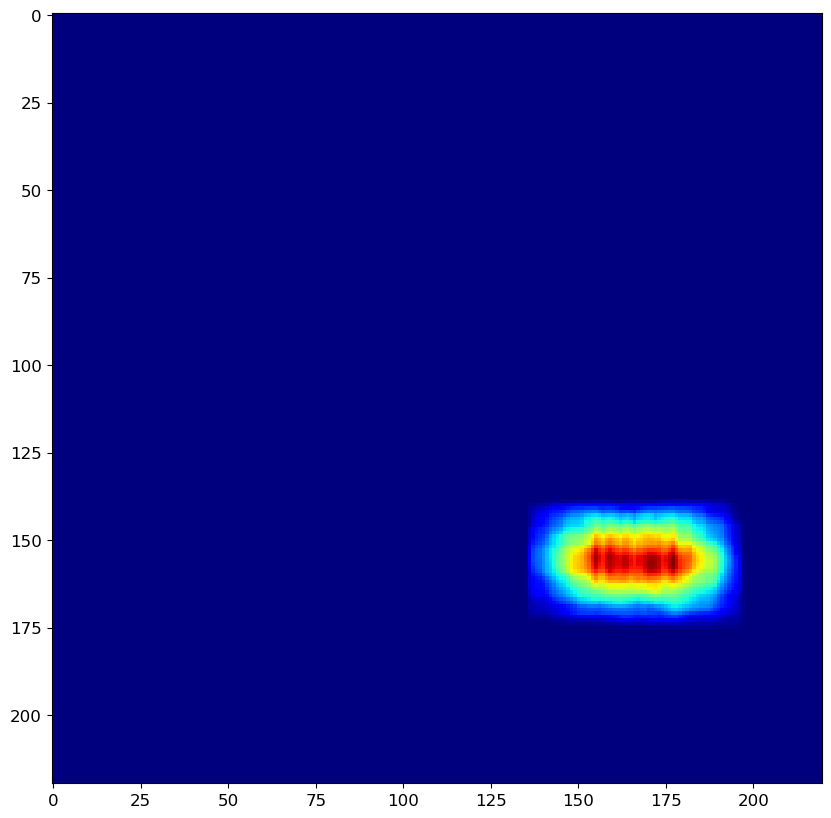

In [113]:
plt.imshow(np.absolute(obj_pos_reassembeled), cmap = 'jet')

In [28]:
global_offsets

<tf.Tensor: shape=(1, 1, 2, 10240), dtype=float64, numpy=
array([[[[38.15054693, 37.96184123, 37.62139586, ..., 62.3902557 ,
          61.85825183, 62.30794668],
         [77.00771349, 77.44443573, 77.43871922, ..., 39.30035574,
          39.08144158, 39.24480746]]]])>

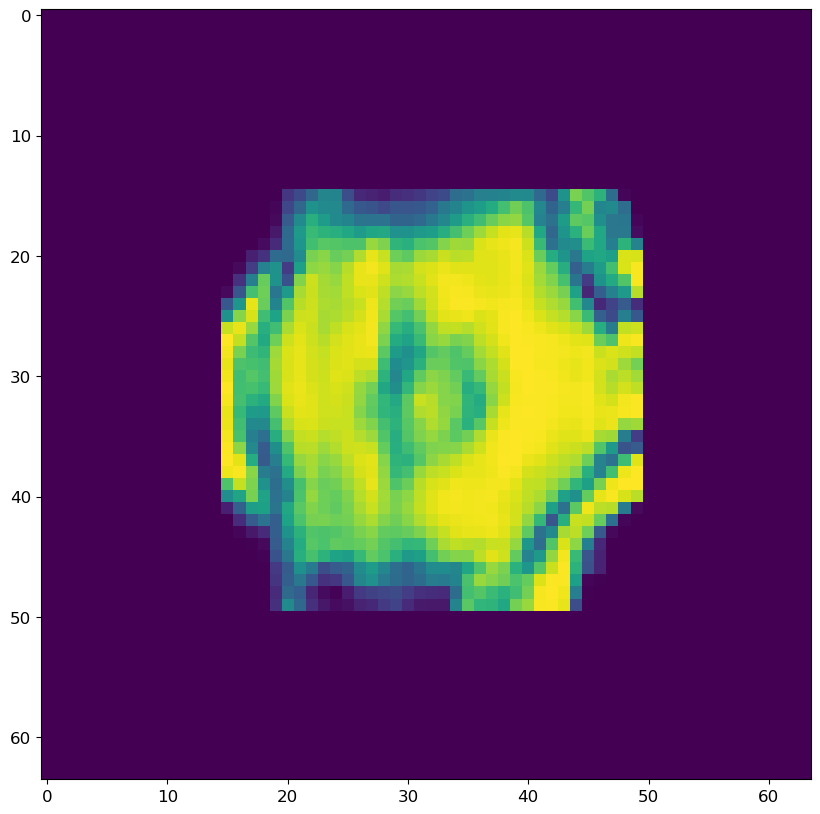

In [10]:
plt.imshow(np.absolute(reconstructed_obj[100]))

phase min: -3.1110606 phase max: 3.1137784


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


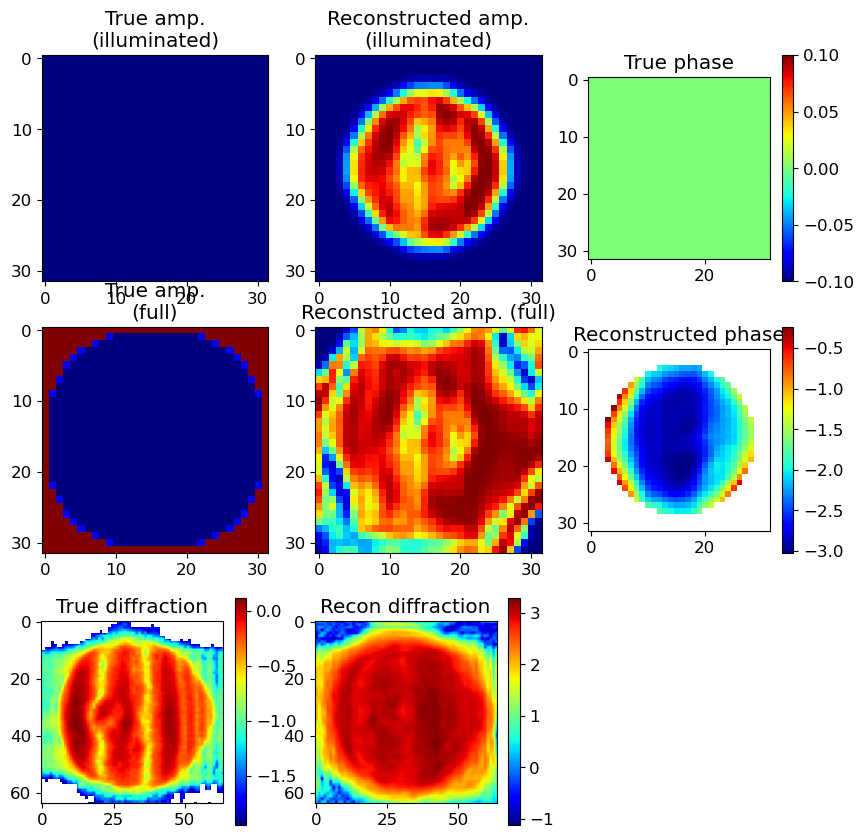

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

In [4]:
from ptycho.xpp import *

In [5]:
pred_amp[100, :, :, 0].mean()

0.7018459

In [6]:
np.absolute(pred_amp).mean()

0.7197135

In [7]:
np.absolute(reconstructed_obj).mean()

0.23019366

In [8]:
from ptycho import model

from ptycho import generate_data as init

In [10]:
probe.set_probe_guess(None, obj['probeGuess']).shape

TensorShape([64, 64, 1])

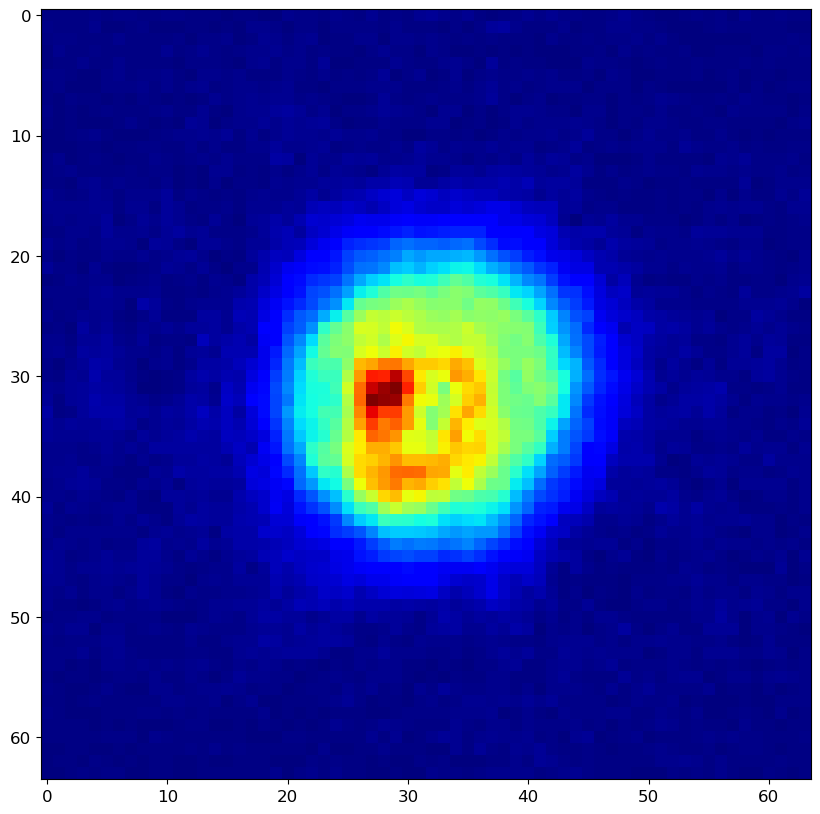

In [7]:
plt.imshow(np.absolute(tf.cast(obj['probeGuess'], tf.complex64)), cmap = 'jet')

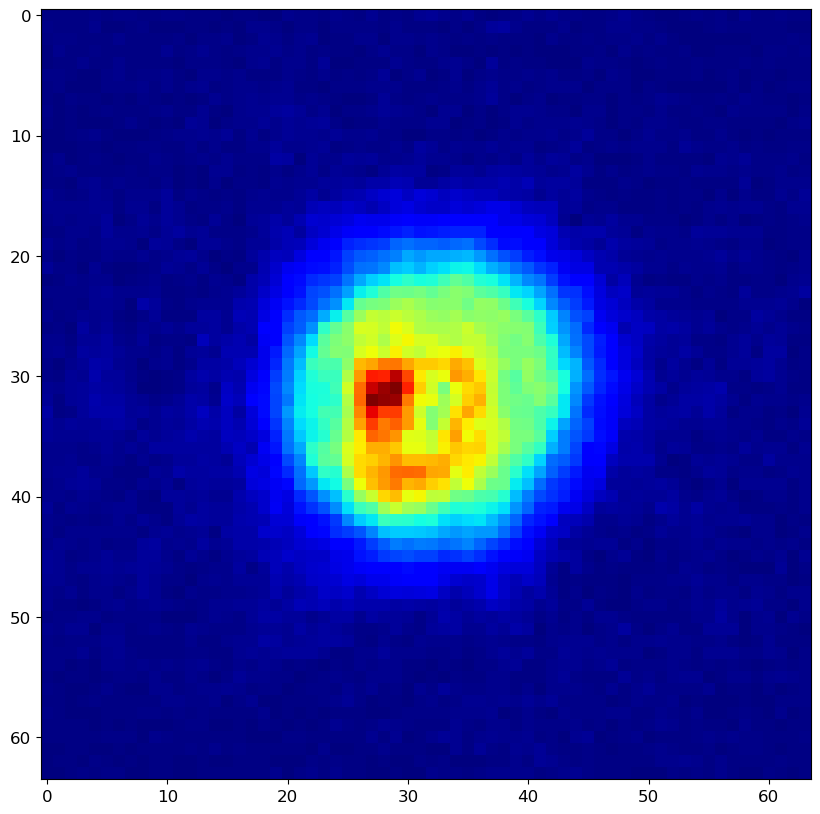

In [12]:
plt.imshow(np.absolute(obj['probeGuess']), cmap = 'jet')

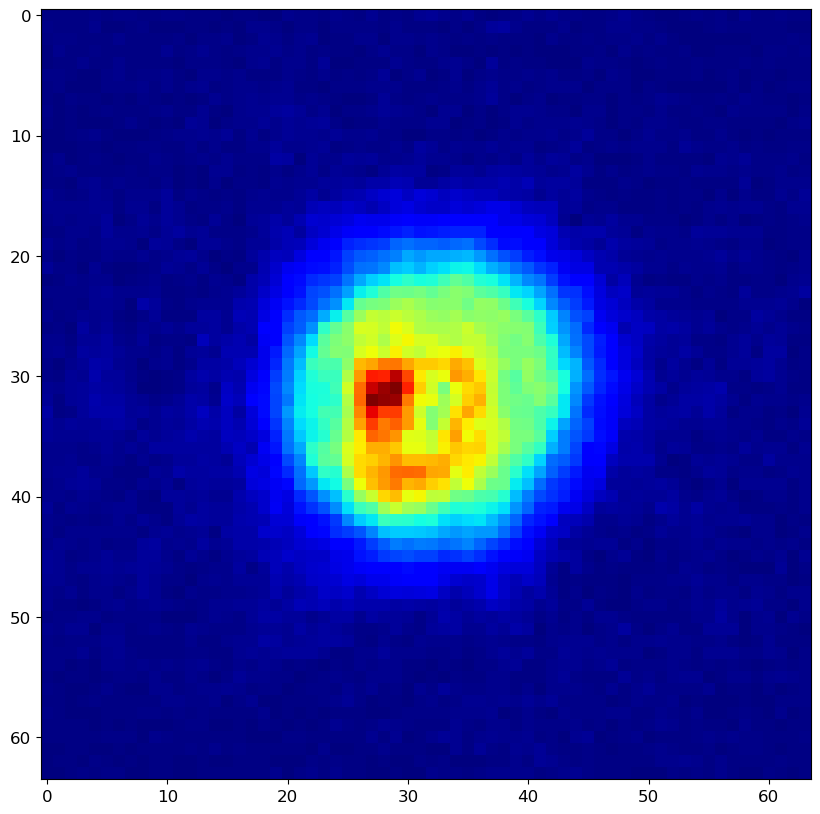

In [13]:
from ptycho import params as p
plt.imshow(np.absolute(p.get('probe')), cmap = 'jet')

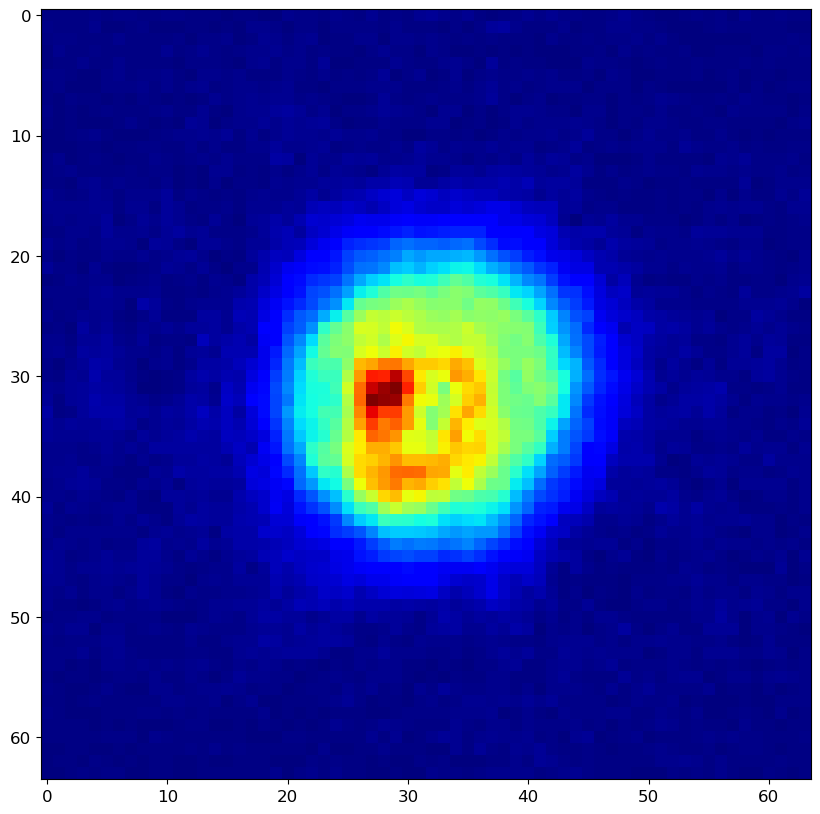

In [8]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')


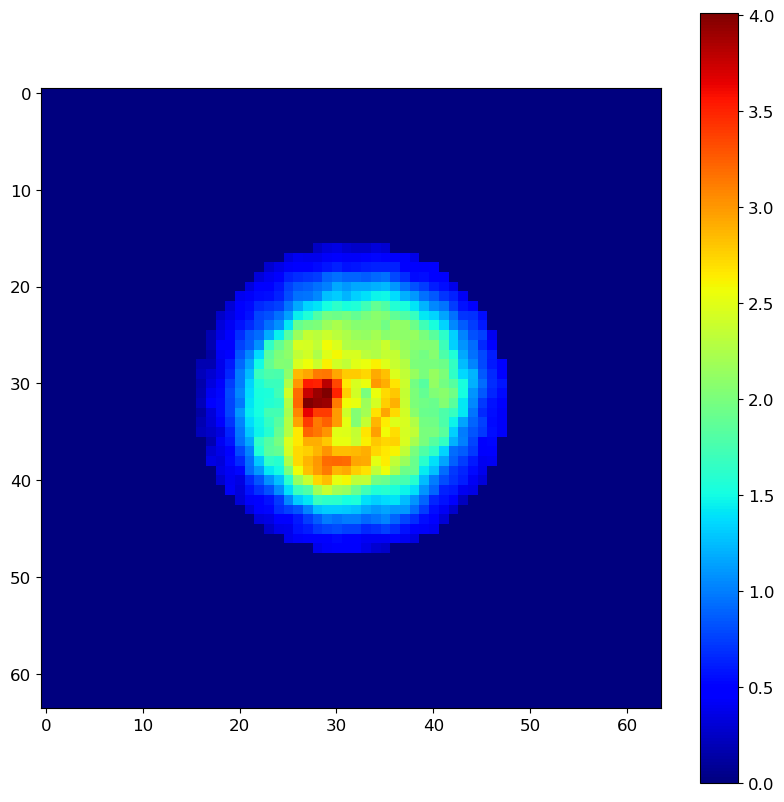

In [10]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]) * probe.probe_mask_real, cmap = 'jet')
plt.colorbar()

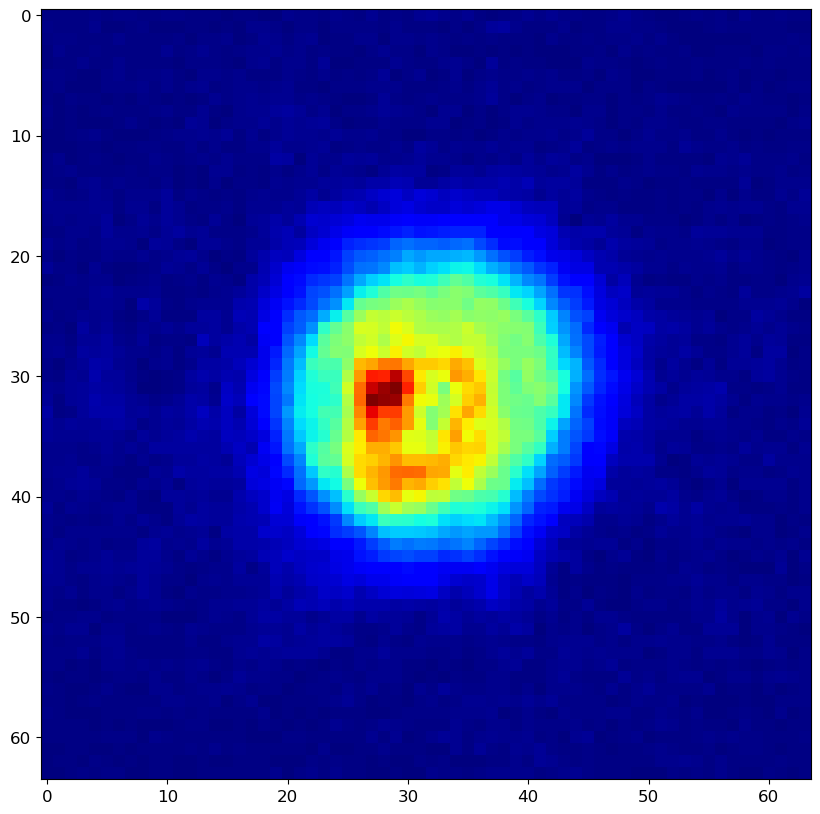

In [8]:
plt.imshow(np.absolute(obj['probeGuess']), cmap = 'jet')

In [15]:
from importlib import reload

In [16]:
reload(evaluation)

<module 'ptycho.evaluation' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py'>

phase min: -3.013871 phase max: 3.0893202


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


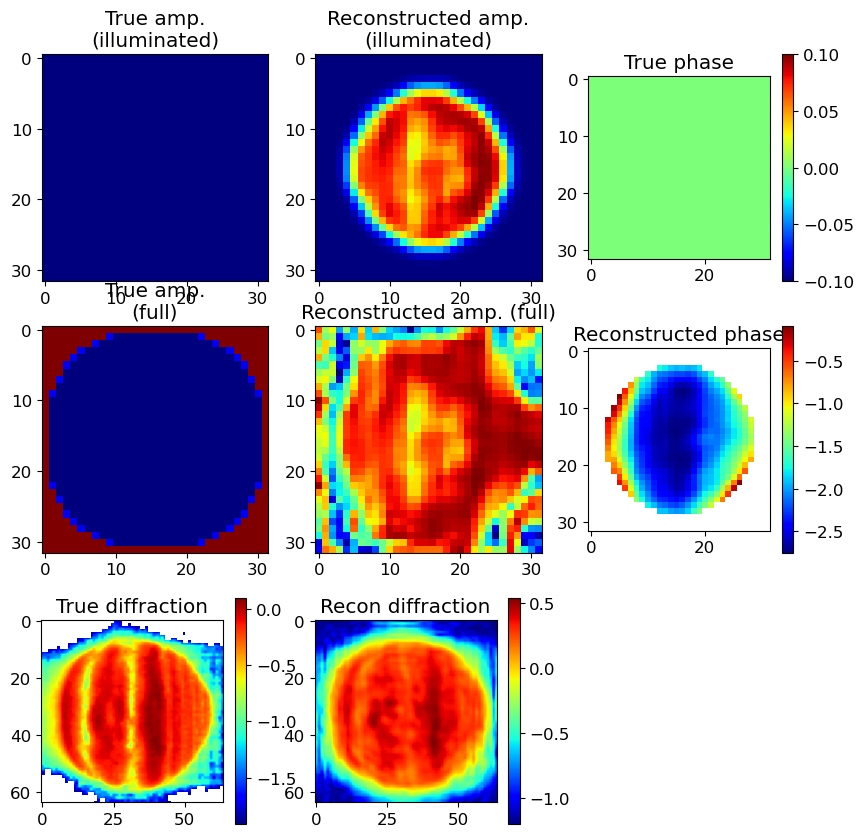

In [11]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1393626 phase max: 3.0823731


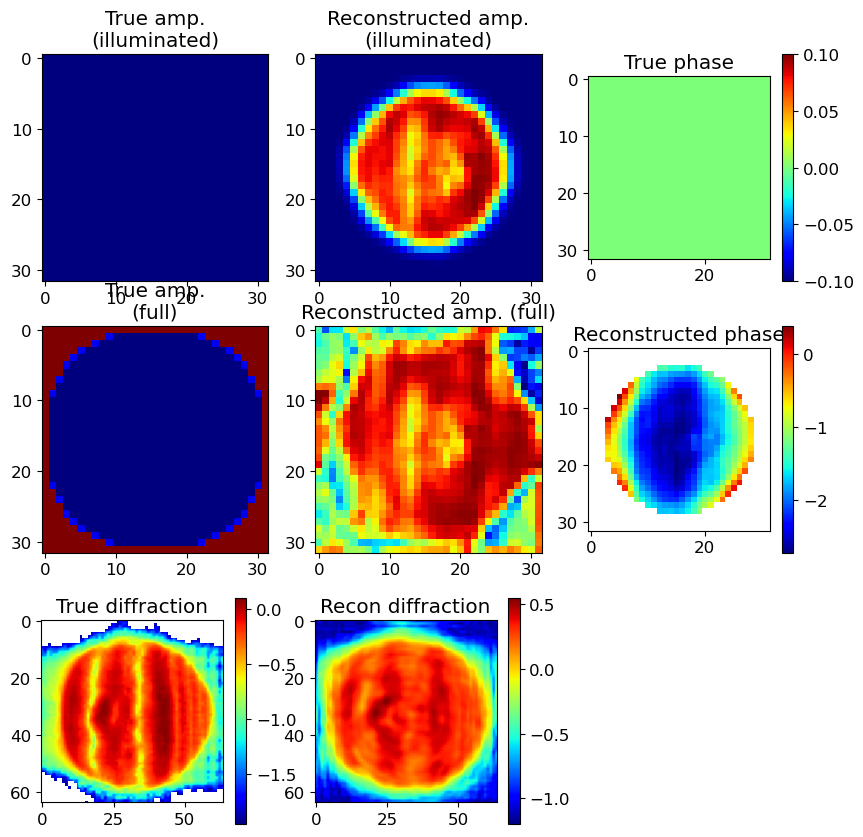

In [18]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1393626 phase max: 3.0823731


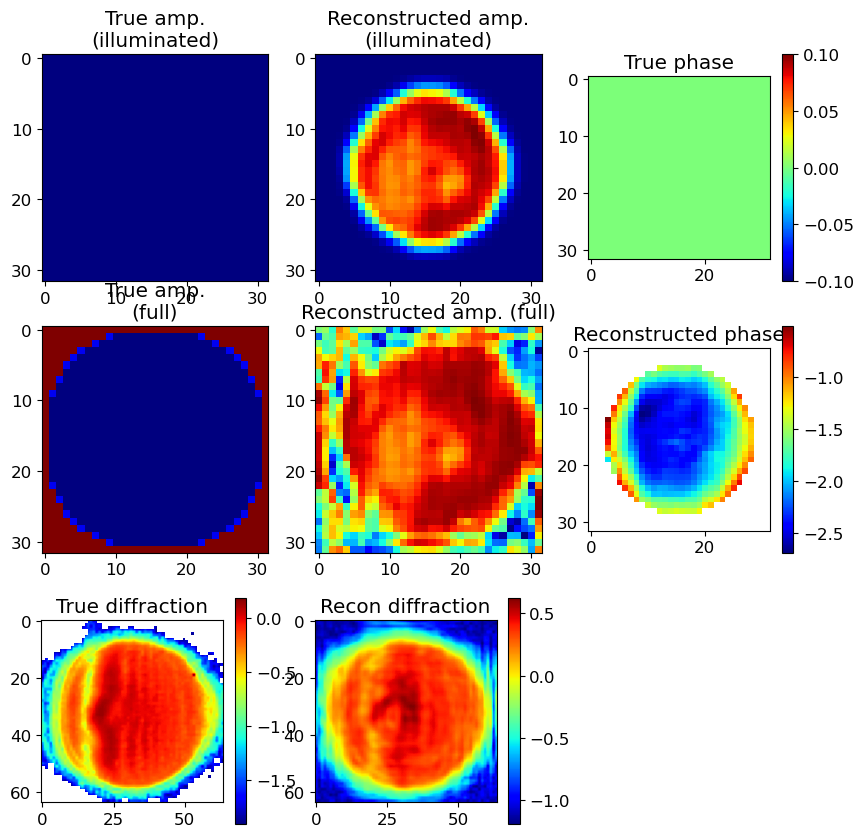

In [17]:
from ptycho import evaluation
i = 1000
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

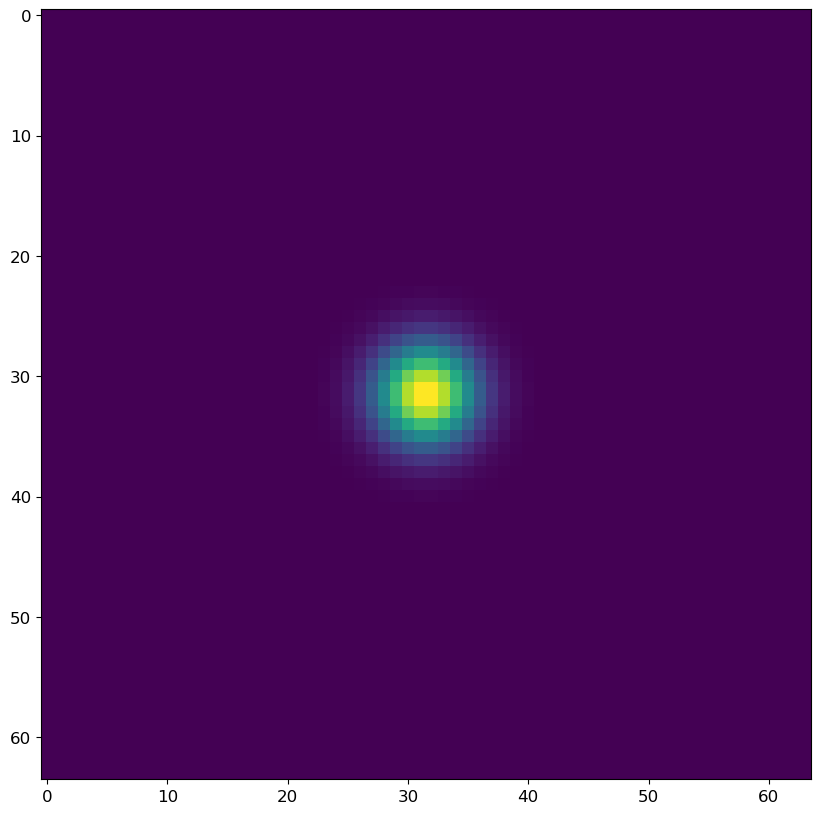

In [24]:
plt.imshow(np.absolute(model.initial_probe_guess))

In [11]:
reconstructed_obj.shape

(424, 64, 64, 1)

In [5]:
from ptycho import datasets

(64, 64)

In [13]:
np.absolute(coords_relative).mean()

1.255082844457051

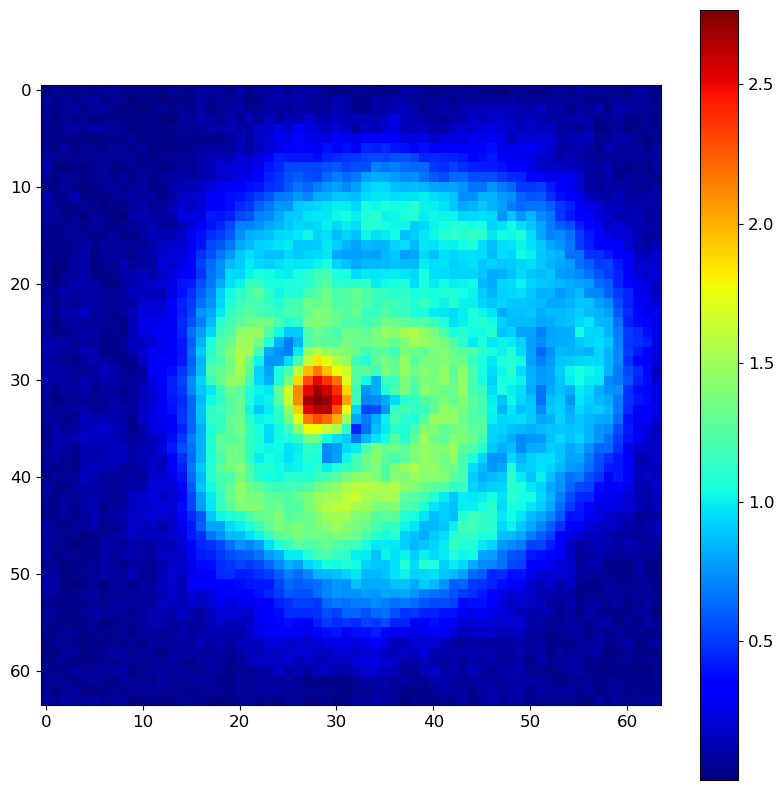

In [17]:
plt.imshow(np.abs(obj['probeGuess']), cmap = 'jet')
plt.colorbar()

In [4]:
np.mean(hh.pad_and_diffract(diff4d_nn[:, :, :, :1], 64, 64)[1]**2)

input shape (1024, 64, 64, 1)


0.30519545

In [5]:
datasets.scale_nphotons(diff4d_nn[:, :, :, :])

<tf.Tensor: shape=(), dtype=float64, numpy=894.7629608593265>

In [6]:
diff4d_nn.shape

(1024, 64, 64, 4)

In [7]:
def stack_coords(xcoords, ycoords, gridh, gridw):
    """
    Takes 1d coord arrays, returns array of shape (1, 2, gridh * gridw)
    """
    return np.array([xcoords, ycoords])[None, ...]

def to_4d(d3d, gridh, gridw):
    """
    Shape 3d data tensor to 4d
    """
    h, w = d3d.shape[:2]
    dgrid = np.transpose(d3d[:, :, :gridh * gridw], [2, 0, 1])
    return dgrid.reshape(gridh, gridw, h, w)

In [73]:
coords3d = stack_coords(xcoords, ycoords, gridh, gridw)
coords3d.shape

(1, 2, 1024)

In [80]:
np.abs(coords_nn - coords_start_nn).mean()

0.5625868095194588

In [71]:
list(obj.keys())

['diffraction',
 'probeGuess',
 'objectGuess',
 'xcoords',
 'ycoords',
 'xcoords_start',
 'ycoords_start']

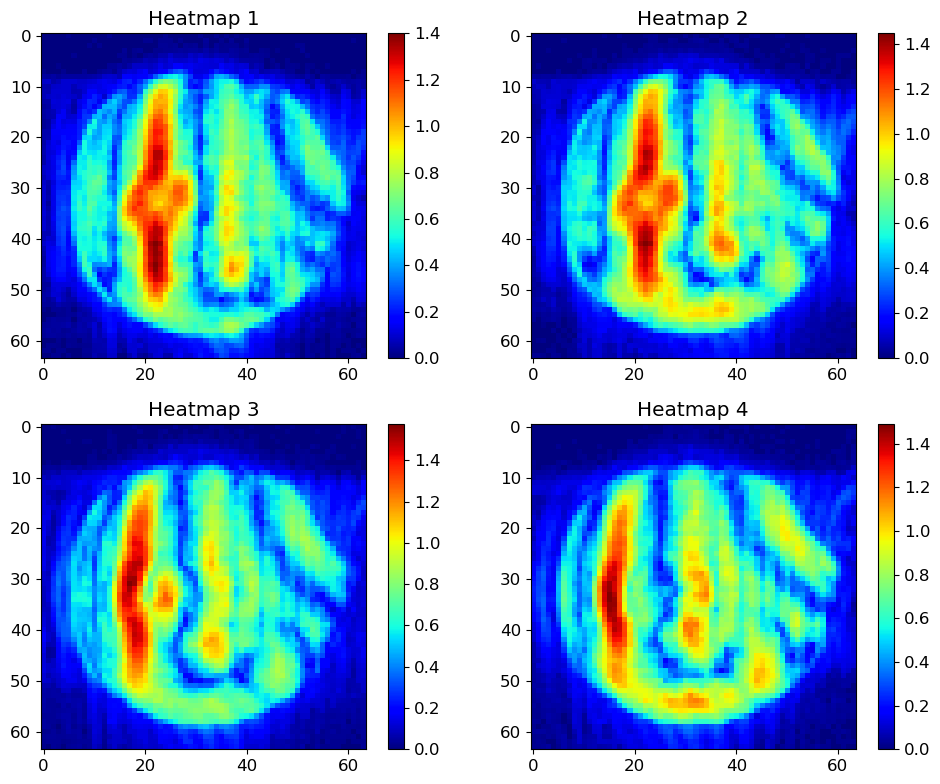

In [34]:
data = diff4d_nn[1000]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Loop through the data and plot each heatmap in a subplot
for i in range(4):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    heatmap = ax.imshow(data[..., i], cmap='jet', interpolation='nearest')
    ax.set_title(f"Heatmap {i + 1}")
    fig.colorbar(heatmap, ax=ax)  # Add colorbar to each subplot

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [12]:
isort = np.argsort(xcoords)
vsort = ycoords[isort]

shp = (8, 32 * 2 * 2)

jjsort = np.argsort(vsort.reshape(shp), axis = 1)

In [13]:
ii, _ = np.indices(shp)

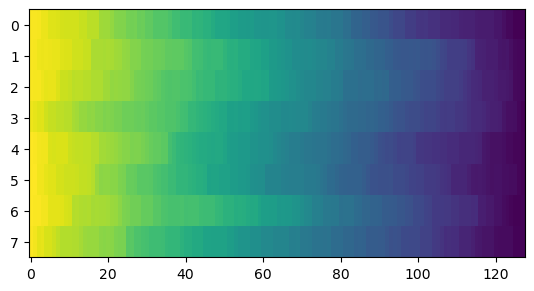

In [14]:
plt.imshow(isort.reshape(shp)[ii, jjsort], aspect = 8)

In [36]:
positions_scangrid = to_4d(coords3d, 32, 32)
X_scangrid = to_4d(obj['diffraction'], 32, 32)

isort_rows = np.argsort(positions_scangrid[:, :, :, 0], axis = 1)
def reorder_scangrid(arr):
    """
    Reorder so that positions are monotonic
    """
    ii, jj, kk, ll = np.indices(arr.shape)
    return arr[ii, isort_rows[..., None], kk, ll]

positions_scangrid = reorder_scangrid(positions_scangrid)
X_scangrid = reorder_scangrid(X_scangrid)

positions_scangrid.shape, X_scangrid.shape

((32, 32, 1, 2), (32, 32, 64, 64))

In [37]:
positions_scangrid.shape

(32, 32, 1, 2)

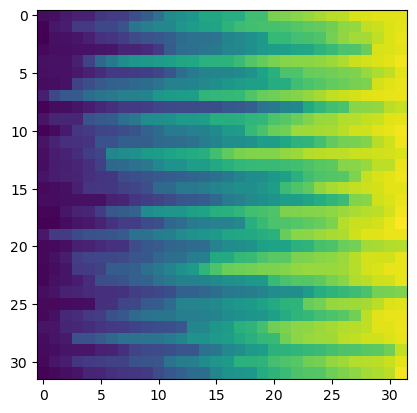

In [96]:
plt.imshow(positions_scangrid[:, :, 0, 0])

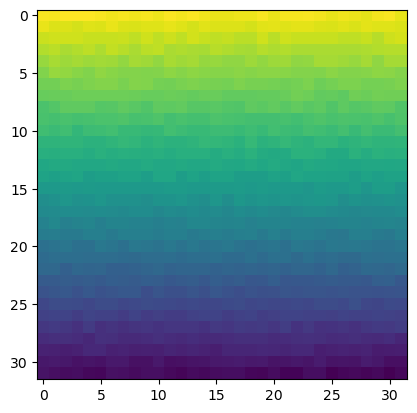

In [97]:
plt.imshow(positions_scangrid[:, :, 0, 1])

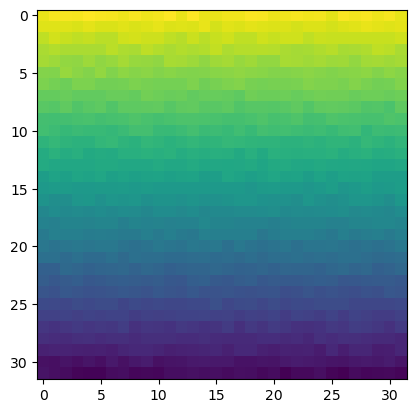

In [161]:
plt.imshow(reorder_scangrid(positions_scangrid)[:, :, 0, 1])

/var/folders/gf/vkyz_q256jnbdk8p30lf19xm0000gn/T/ipykernel_6815/3442418750.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_scangrid[10, 10, :, :]))


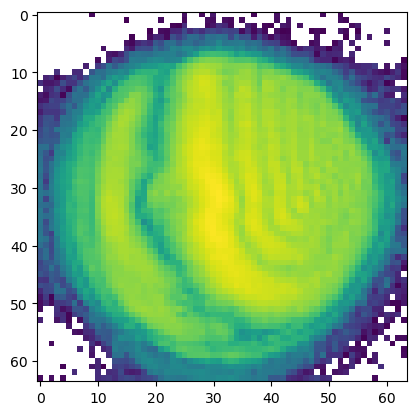

In [98]:
plt.imshow(np.log(X_scangrid[10, 10, :, :]))

In [90]:
def prepare_from_4d(diff4d, h, w):
    """
    Extract solution patches and return them in channel format, shape (b, h, w, c)
    """
    solution_regions_grid = hh.extract_patches(diff4d.reshape(1, 32, 32, h * w), gridsize, 1)
    solution_regions_channel = tf.reshape(solution_regions_grid, (-1, gridsize**2, h, w))
    return tf.transpose(solution_regions_channel, [0, 2, 3, 1], conjugate = False)

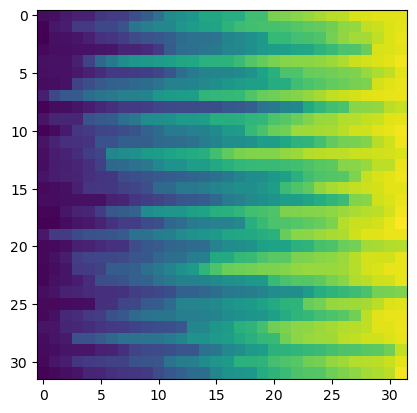

In [162]:
plt.imshow(positions_scangrid[:, :, 0, 0])

In [94]:
# diffraction data in the model's input format
X = prepare_from_4d(X_scangrid, N, N)

# scan point positions in the model's input format
positions = prepare_from_4d(positions_scangrid, 1, 2)

X.shape, positions.shape

(TensorShape([961, 64, 64, 4]), TensorShape([961, 1, 2, 4]))

<tf.Tensor: shape=(1, 2, 4), dtype=float64, numpy=
array([[[ 78.73525601,  78.79744924, 112.54909053, 115.64263298],
        [146.80767817, 145.42123453, 142.5542574 , 144.8813778 ]]])>

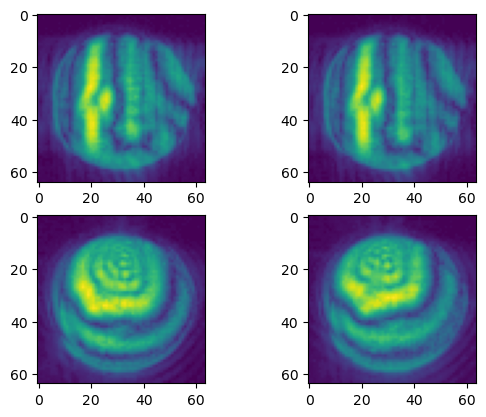

In [95]:
# four diffraction patterns from one solution grid
a, b = 2, 2
plt.subplot(a, b, 1)
plt.imshow(X[100, :, :, 0])

plt.subplot(a, b, 2)
plt.imshow(X[100, :, :, 1])

plt.subplot(a, b, 3)
plt.imshow(X[100, :, :, 2])

plt.subplot(a, b, 4)
plt.imshow(X[100, :, :, 3])

positions[100, :, :, :]

In [2]:
from importlib import reload
import matplotlib.pyplot as plt

from ptycho import params as p
from ptycho import generate_data as init
# from ptycho import train

Loading result from disk cache.
Loading result from disk cache.
0.9999917
nphoton 8.962649


In [3]:
p.cfg['outer_offset_train']

NameError: name 'p' is not defined

In [4]:
p.cfg['outer_offset_test']

NameError: name 'p' is not defined

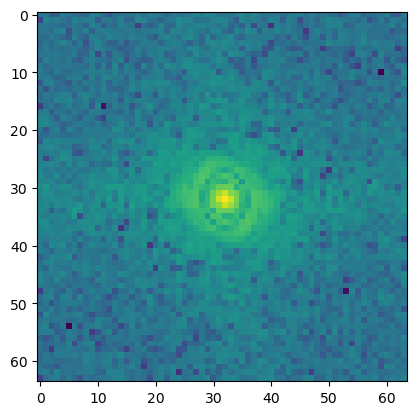

In [170]:
plt.imshow(
    np.log(np.absolute(np.fft.fftshift(np.fft.fft2(np.absolute(obj['probeGuess']))))))

In [6]:
from ptycho import tf_helper as hh

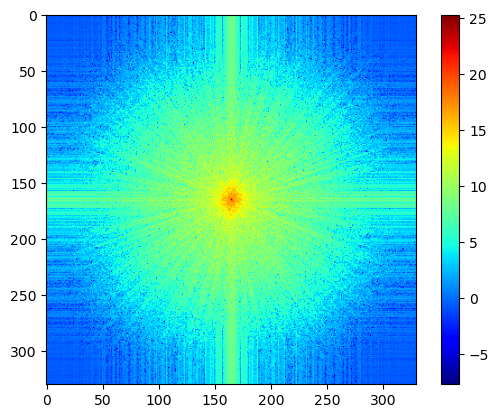

In [7]:
from ptycho import evaluation as eval
import numpy as np
reload(eval)

F2 = np.absolute(eval.fft2d(np.absolute(init.YY_ground_truth[:, :, 0])))**2

plt.imshow(np.log(F2[:, :]), cmap = 'jet')
plt.colorbar()

In [8]:
size = (np.array(init.YY_ground_truth[:, :, 0]).size)

## Full PINN model, best params:

In [10]:
# plt.plot(d['frc'][0])
# plt.plot(d['frc'][1])


In [11]:
d = save_metrics(stitched_obj, YY_ground_truth, label = 'PINN,NLL,overlaps')
d
#d0 = d

subtracting mean 0.06457644
subtracting mean 0.15387884
mean scale adjustment: 4.346844
mean scale adjustment: 4.346844
performed by index method
performed by index method
performed by index method
mean scale adjustment: 1
mean scale adjustment: 1
performed by index method
performed by index method
performed by index method


{'mae': (0.036913663, 0.014299419),
 'mse': (0.0026327244, 0.0003312106),
 'psnr': (73.9267499156581, 82.92976135806056),
 'frc50': (165, 165)}

In [14]:
d = save_metrics(stitched_obj, YY_ground_truth, label = 'PINN,NLL,overlaps')
d
#d0 = d

subtracting mean -0.18307073
subtracting mean 0.15387884
mean scale adjustment: 4.566107
mean scale adjustment: 4.566107
performed by index method
performed by index method
performed by index method
mean scale adjustment: 1
mean scale adjustment: 1
performed by index method
performed by index method
performed by index method


{'mae': (0.18717046, 0.10040524),
 'mse': (0.052955687, 0.015191995),
 'psnr': (60.89167790517977, 66.31465531094665),
 'frc50': (22, 20)}

In [12]:
stitched_phase = np.angle(stitched_obj)#init.stitch(b, 1, norm = False, nsegments = params()['nsegments'],
                       #part = 'phase')

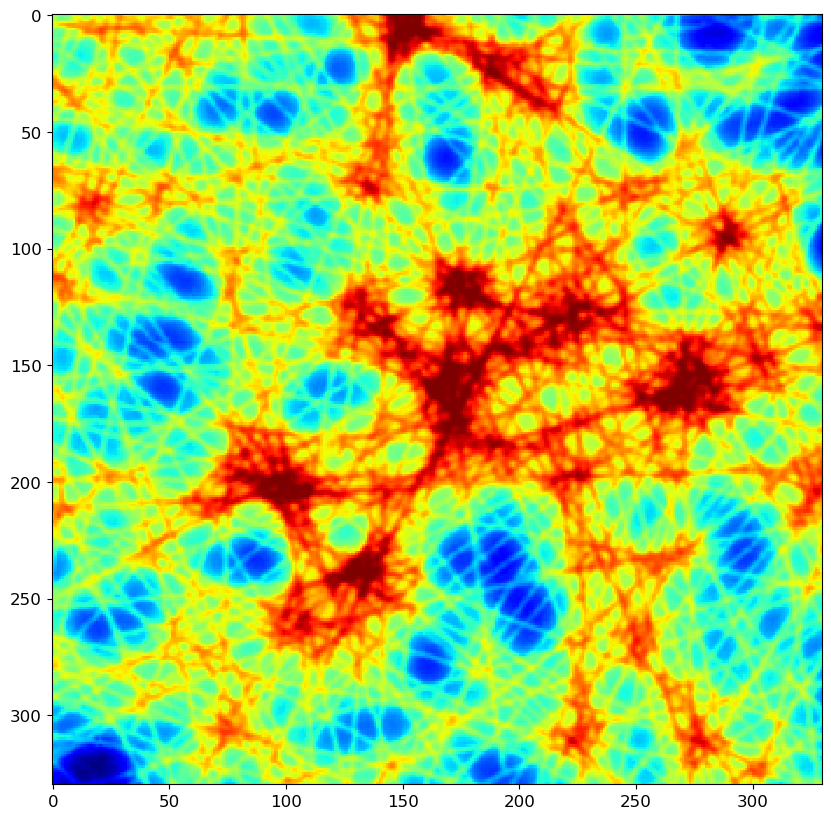

In [12]:
plt.rcParams["figure.figsize"] = (10, 10)
 
import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

In [12]:
stitched_obj.shape

(2, 330, 330, 1)

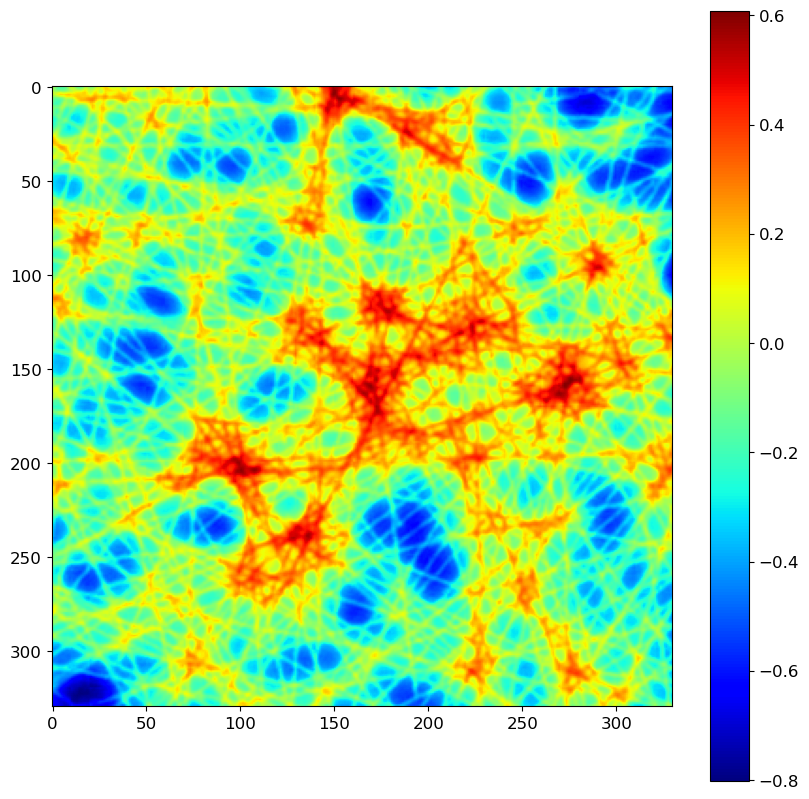

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)

plt.imshow(np.angle(stitched_obj)[0], cmap = 'jet')
plt.colorbar()